In [4]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit # Sigmoid function

# --- 1. Load Your Data ---
# We assume the CSV has no header row and the first column is the model name
try:
    df = pd.read_csv('data/lsat_resmat.csv', header=None, index_col=0)
except FileNotFoundError:
    print("Error: lsat_resmat.csv not found. Please make sure it's in the same directory.")
    # Create dummy data to allow the rest of the script to be checked
    df = pd.DataFrame(np.random.randint(0, 2, size=(10, 81)), 
                      index=[f'model_{i}' for i in range(10)])

# Convert the response matrix to a numpy array
Y_data = df.values

# Get model and item names for later
model_names = df.index.tolist()
item_names = [f'item_{i}' for i in range(Y_data.shape[1])]

print(f"Data shape (N_persons, I_items): {Y_data.shape}")

Data shape (N_persons, I_items): (69, 454)


In [5]:
# --- 2. Define Model Parameters ---
N_persons, I_items = Y_data.shape
K_dims = 3 # Based on your F1, F2, F3

print(f"Persons (Models): {N_persons}, Items (Questions): {I_items}, Dims: {K_dims}")

# --- 3. Define Anchor Priors ---
# Priors for items strongly associated with a dimension
alpha_anchor_1 = [10.0, 0.5, 0.5]  # Strong prior for F1
alpha_anchor_2 = [0.5, 10.0, 0.5]  # Strong prior for F2
alpha_anchor_3 = [0.5, 0.5, 10.0]  # Strong prior for F3

# A sparse prior for all *other* items
alpha_sparse = [0.5, 0.5, 0.5]

# --- 4. Build the Anchor Matrix ---
# Your R-style 1-indexed anchors
anchors_F1_r = [1, 12, 19, 27]
anchors_F2_r = [3, 7, 11, 23]
anchors_F3_r = [5, 17, 31, 53, 81]

# Convert to Python-style 0-indexing
# This is CRUCIAL!
anchors_F1_py = [i - 1 for i in anchors_F1_r]
anchors_F2_py = [i - 1 for i in anchors_F2_r]
anchors_F3_py = [i - 1 for i in anchors_F3_r]

# Create the full (I_items, K_dims) prior matrix, starting all sparse
alpha_prior_matrix = np.tile(alpha_sparse, (I_items, 1))

# Now, set the strong anchor priors at the specific indices
try:
    for idx in anchors_F1_py:
        alpha_prior_matrix[idx] = alpha_anchor_1
    for idx in anchors_F2_py:
        alpha_prior_matrix[idx] = alpha_anchor_2
    for idx in anchors_F3_py:
        alpha_prior_matrix[idx] = alpha_anchor_3
except IndexError:
    print(f"--- ERROR ---")
    print(f"Your anchor indices go up to {max(anchors_F1_r + anchors_F2_r + anchors_F3_r)},")
    print(f"but your data file only has {I_items} items (columns).")
    print(f"Please check your anchor lists or data file.")

print("Successfully built anchor prior matrix.")
print(f"Prior for Item 1 (idx 0, F1): {alpha_prior_matrix[0]}")
print(f"Prior for Item 2 (idx 1, sparse): {alpha_prior_matrix[1]}")
print(f"Prior for Item 3 (idx 2, F2): {alpha_prior_matrix[2]}")

Persons (Models): 69, Items (Questions): 454, Dims: 3
Successfully built anchor prior matrix.
Prior for Item 1 (idx 0, F1): [10.   0.5  0.5]
Prior for Item 2 (idx 1, sparse): [0.5 0.5 0.5]
Prior for Item 3 (idx 2, F2): [ 0.5 10.   0.5]


In [6]:
# Coordinates for plotting
coords = {
    "person": model_names,
    "item": item_names,
    "dim": ["F1", "F2", "F3"]
}

with pm.Model(coords=coords) as dirichlet_mirt_real:
    
    Y_obs = pm.Data("Y_obs", Y_data, dims=("person", "item"))

    # --- Person Parameters (CENTERED) ---
    theta = pm.Normal("theta", mu=0, sigma=1, dims=("person", "dim"))

    # --- Item Parameters (CENTERED) ---
    d = pm.Normal("d", mu=0, sigma=5, dims="item")
    g = pm.LogNormal("g", mu=0, sigma=1, dims="item")
    
    # --- Anchored 'w' Prior ---
    # This now uses our custom matrix with anchors at specific indices
    w = pm.Dirichlet("w", a=alpha_prior_matrix, dims=("item", "dim"))

    
    # --- Linear Predictor & Likelihood ---
    dot_prod = pt.dot(theta, w.T)
    L = pm.Deterministic("L", d + g * dot_prod)
    Y_hat = pm.Bernoulli("Y_hat", logit_p=L, observed=Y_obs, dims=("person", "item"))

# --- 4. Fit the Model ---
# This will take some time with real data
with dirichlet_mirt_real:
    trace = pm.sample(2000, tune=1500, chains=4, cores=8, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, d, g, w]


Output()

ValueError: Not enough samples to build a trace.

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
d[item_0]       0.614  1.147  -1.357    2.749      0.024    0.034    3054.0   
d[item_1]       3.064  1.629   0.398    6.083      0.023    0.030    6937.0   
d[item_2]       0.610  1.023  -1.104    2.494      0.019    0.033    3951.0   
d[item_3]       0.466  0.764  -0.932    1.878      0.009    0.014    7381.0   
d[item_4]       0.490  0.783  -0.982    1.917      0.011    0.019    6544.0   
...               ...    ...     ...      ...        ...      ...       ...   
w[item_79, F2]  0.379  0.288   0.000    0.881      0.003    0.002    7499.0   
w[item_79, F3]  0.327  0.284   0.000    0.851      0.003    0.002    5924.0   
w[item_80, F1]  0.051  0.068   0.000    0.183      0.001    0.001    5887.0   
w[item_80, F2]  0.046  0.060   0.000    0.161      0.001    0.001    6026.0   
w[item_80, F3]  0.904  0.088   0.737    1.000      0.001    0.001    5976.0   

                ess_tail  r_hat  
d[item_0]        

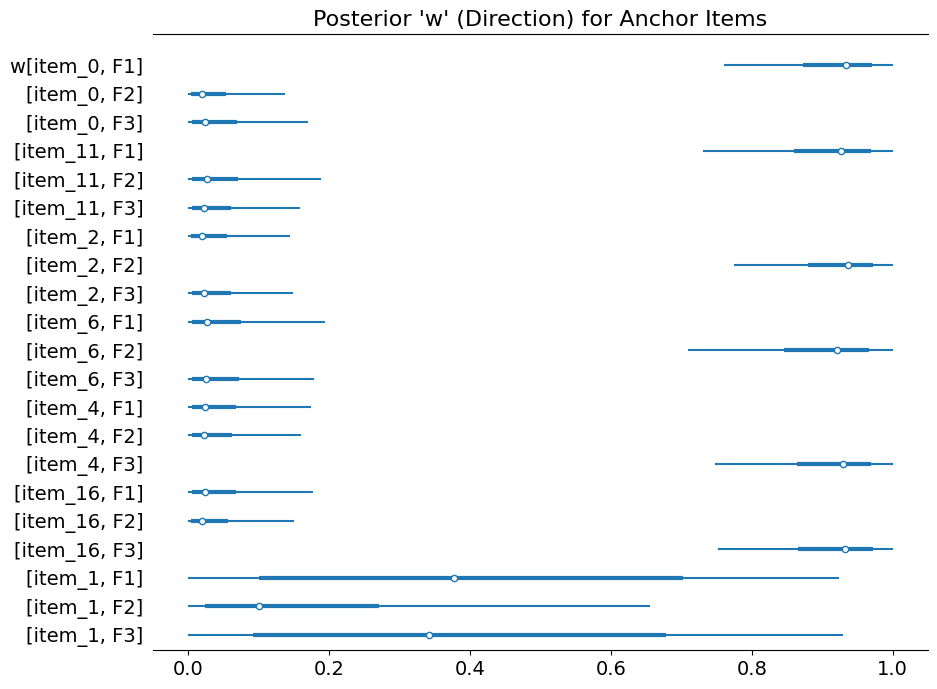

In [ ]:
# --- 1. Check Convergence ---
summary = az.summary(trace, var_names=["d", "g", "w"])
print(summary)

# Check for any r_hat > 1.01
if (summary["r_hat"] > 1.01).any():
    print("\nWARNING: Poor convergence detected! Check r_hat values.")
else:
    print("\nSUCCESS: All r_hat values look good. Convergence achieved.")


# --- 2. Plot Anchor Item 'w' Parameters ---
# This is the best way to see if the dimensions were identified.
# We will plot the 'w' (direction) parameters for a few anchors
# from each dimension.

# Get the Python 0-indices of the items you want to plot
items_to_plot = [
    anchors_F1_py[0],  # First F1 anchor (item 1)
    anchors_F1_py[1],  # Second F1 anchor (item 12)
    anchors_F2_py[0],  # First F2 anchor (item 3)
    anchors_F2_py[1],  # Second F2 anchor (item 7)
    anchors_F3_py[0],  # First F3 anchor (item 5)
    anchors_F3_py[1],  # Second F3 anchor (item 17)
    1 # A sparse item (item 2) for comparison
]

# Get the corresponding item names for the plot
item_labels_to_plot = [item_names[i] for i in items_to_plot]

# Create the forest plot
az.plot_forest(
    trace,
    var_names=["w"],
    # Select only the specific items we chose above
    coords={"item": item_labels_to_plot},
    combined=True,
    hdi_prob=0.94,
    figsize=(10, 8)
)
plt.title("Posterior 'w' (Direction) for Anchor Items", fontsize=16)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.special import expit # This is the sigmoid function: 1 / (1 + exp(-x))
import matplotlib.pyplot as plt

# 1. Get the posterior mean of the linear predictor 'L'
# L was defined in our model. The trace object stores all samples.
# Shape will be (N_persons, I_items)
L_mean = trace.posterior["L"].mean(dim=("chain", "draw"))

# 2. Convert the log-odds (L) to probabilities (P) using the sigmoid function
P_predicted = expit(L_mean)

# 3. Flatten the arrays to 1D for sklearn
y_true_flat = Y_data.flatten()
y_pred_flat = P_predicted.values.flatten() # .values converts from xarray to numpy

# 4. Calculate the AUC Score
auc_score = roc_auc_score(y_true_flat, y_pred_flat)
print(f"Model AUC Score: {auc_score:.4f}")

# 5. Calculate the ROC curve points (FPR, TPR)
fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred_flat)

# 6. Plot the ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()